In [206]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as ss
from collections import Counter
%matplotlib inline

In [332]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

In [315]:
df_sessions = pd.read_json(path_or_buf='../../data/raw/sessions.jsonl', lines=True)
df_users = pd.read_json(path_or_buf='../../data/raw/users.jsonl', lines=True)

In [316]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5,NaN
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5,20001.0
2,125,2021-09-12 16:43:16,102,1076,VIEW_PRODUCT,0,NaN
3,125,2021-09-12 16:46:24,102,1080,VIEW_PRODUCT,0,NaN
4,125,2021-09-12 16:48:08,102,1079,VIEW_PRODUCT,0,NaN


In [317]:
df_users.head()

,user_id,name,city,street
0,102,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
1,103,Mateusz Kobel,Poznań,al. Wrocławska 10
2,104,Radosław Ratka,Szczecin,pl. Nowa 89/04
3,105,Anastazja Oszust,Warszawa,ul. Częstochowska 80
4,106,Sylwia Nurek,Warszawa,al. Wiosenna 72


# Agregacja informacji o sesjach

Nie bierzemy **purchase_id** pod uwagę, ponieważ nie będziemy mieli tej informacji przed zakończeniem sesji.<br>
- Z kolumny **timestamp** istotny może być początek i koniec sesji, a także czas jej trwania
- **event_type** niesie informację, czy sesja zakończyła się zakupem, czy też nie - będzie to nasza kolumna, której wartość będziemy przewidywać
- tymczasowo przechowujemy w liście wszystkie **product_id** przeglądane w trakcie sesji - długość tej listy - 1 może również nieść informacje o tym, ile było wszystkich wyświetleń przedmiotów w trakcie sesji

In [318]:
aggregation_functions = {
    'timestamp' : lambda t: [(t.max() - t.min()).seconds, t.min(), t.max()],
    'user_id' : 'first',
    'product_id' : 'unique',
    'event_type' : lambda e: 1 if len(e.unique()) > 1 else 0,
    'offered_discount' : 'first'
}
agg_sessions_df = df_sessions.groupby(df_sessions['session_id']).aggregate(aggregation_functions)
agg_sessions_df.rename(columns={'event_type' : 'purchased'}, inplace=True)

In [319]:
agg_sessions_df.head()

,timestamp,user_id,product_id,purchased,offered_discount
session_id,,,,,
124,"[19, 2021-07-28 15:47:21, 2021-07-28 15:47:40]",102,[1283],1,5
125,"[1436, 2021-09-12 16:43:16, 2021-09-12 17:07:12]",102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",1,0
126,"[117, 2021-04-09 22:31:08, 2021-04-09 22:33:05]",102,"[1281, 1278]",1,15
127,"[519, 2021-08-15 16:46:06, 2021-08-15 16:54:45]",102,"[1278, 1281]",1,0
128,"[847, 2021-01-05 00:05:38, 2021-01-05 00:19:45]",102,"[1008, 1007, 1013, 1012, 1004, 1010]",1,0


In [320]:
timestamp_dict = [{'session_length' : x[0], 'session_start' : x[1], 'session_end' : x[2]} for x in agg_sessions_df['timestamp']]

In [321]:
timestamp_df = pd.DataFrame(timestamp_dict)

In [322]:
agg_sessions_df = pd.concat([agg_sessions_df, timestamp_df], axis=1, join="inner")
agg_sessions_df.drop(columns=['timestamp'], inplace=True)
agg_sessions_df.index.name = 'session_id'
agg_sessions_df.head()

,user_id,product_id,purchased,offered_discount,session_length,session_start,session_end
session_id,,,,,,,
124,102,[1283],1,5,725,2021-08-26 22:27:52,2021-08-26 22:39:57
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",1,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11
126,102,"[1281, 1278]",1,15,347,2021-02-16 17:40:31,2021-02-16 17:46:18
127,102,"[1278, 1281]",1,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",1,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51


# Połączenie tabeli sesji i użytkowników

Z tabeli użytkowników istotną informację może nieść miasto w którym mieszka użytkownik - kolumna **city**

In [323]:
df = agg_sessions_df.join(other=df_users.set_index('user_id'), on='user_id')
df.drop(columns=['name', 'street'], inplace=True)

# Zmiana kolejności kolumn, żeby przewidywana kolumna, czyli purchased, była ostanią kolumną
df = df[['user_id', 'product_id', 'offered_discount', 'session_length', 'session_start', 'session_end', 'city', 'purchased']]

In [324]:
df.head()

,user_id,product_id,offered_discount,session_length,session_start,session_end,city,purchased
session_id,,,,,,,,
124,102,[1283],5,725,2021-08-26 22:27:52,2021-08-26 22:39:57,Poznań,1
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,Poznań,1
126,102,"[1281, 1278]",15,347,2021-02-16 17:40:31,2021-02-16 17:46:18,Poznań,1
127,102,"[1278, 1281]",0,457,2021-03-13 06:48:13,2021-03-13 06:55:50,Poznań,1
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,Poznań,1


In [325]:
df.describe()

,user_id,offered_discount,session_length,purchased
count,9403.000000,9403.000000,9403.000000,9403.000000
mean,196.955652,5.092524,407.411996,0.582155
std,58.246122,7.107596,415.401841,0.493231
min,102.000000,0.000000,0.000000,0.000000
25%,147.000000,0.000000,100.000000,0.000000
50%,193.000000,0.000000,259.000000,1.000000
75%,246.000000,10.000000,603.500000,1.000000
max,300.000000,20.000000,2202.000000,1.000000


# Analiza danych

## Czy zbiór jest zbalansowany?

In [326]:
sessions_with_purchase = df.loc[df['purchased'] == 1]

In [327]:
sessions_without_purchase = df.loc[df['purchased'] == 0]

Text(0, 0.5, 'Liczba sesji')

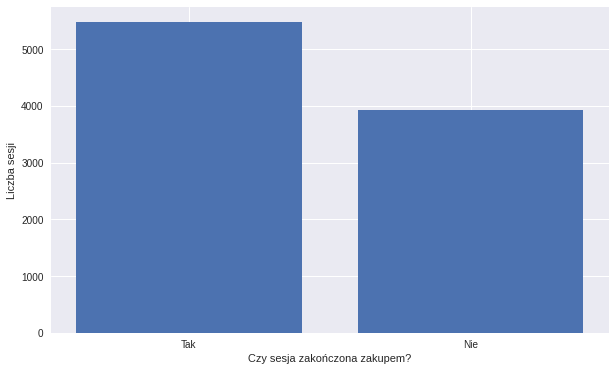

In [333]:
plt.bar(['Tak', 'Nie'], [sessions_with_purchase.shape[0], sessions_without_purchase.shape[0]])
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Liczba sesji')

## Długość trwania sesji

Text(0, 0.5, 'Liczba sesji')

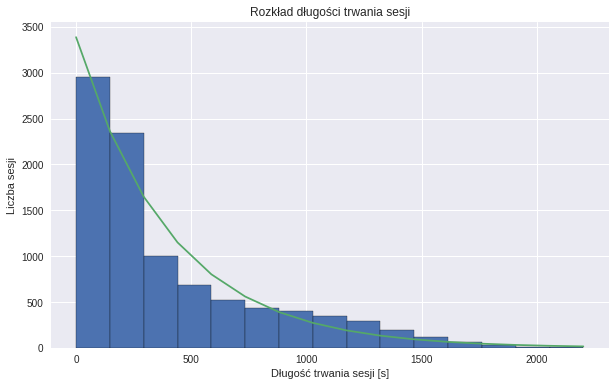

In [334]:
P = ss.expon.fit(df['session_length'])
n, bins, patches = plt.hist(df['session_length'], bins=15, edgecolor='black')
y = ss.expon.pdf(bins, *P) * np.sum(n * np.diff(bins))
plt.plot(bins, y)
plt.title('Rozkład długości trwania sesji')
plt.xlabel('Długość trwania sesji [s]')
plt.ylabel('Liczba sesji')

Text(0, 0.5, 'Liczba sesji')

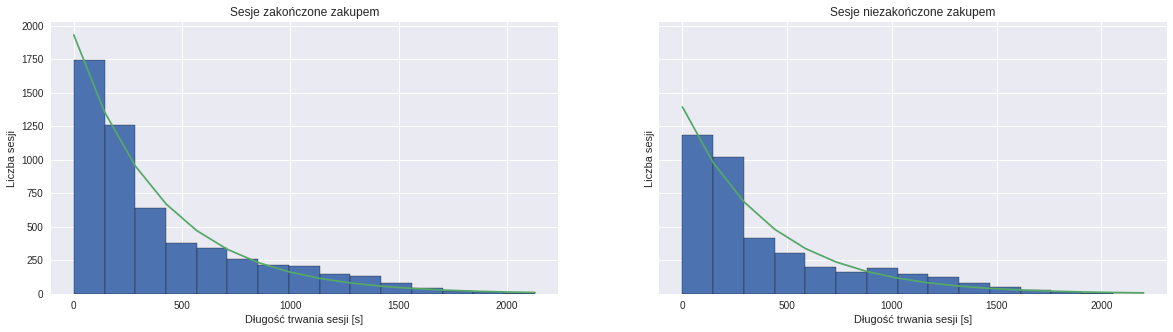

In [335]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

n0, bins0, patches0 = ax[0].hist(sessions_with_purchase['session_length'], bins=15, edgecolor='black')
P0 = ss.expon.fit(sessions_with_purchase['session_length'])
y0 = ss.expon.pdf(bins0, *P0) * np.sum(n0 * np.diff(bins0))
ax[0].plot(bins0, y0)
ax[0].set_title('Sesje zakończone zakupem')
ax[0].set_xlabel('Długość trwania sesji [s]')
ax[0].set_ylabel('Liczba sesji')

n1, bins1, patches1 = ax[1].hist(sessions_without_purchase['session_length'], bins=15, edgecolor='black')
P1 = ss.expon.fit(sessions_without_purchase['session_length'])
y1 = ss.expon.pdf(bins1, *P1) * np.sum(n1 * np.diff(bins1))
ax[1].plot(bins1, y1)
ax[1].set_title('Sesje niezakończone zakupem')
ax[1].set_xlabel('Długość trwania sesji [s]')
ax[1].set_ylabel('Liczba sesji')

Text(0, 0.5, 'Średnia długość trwania sesji [s]')

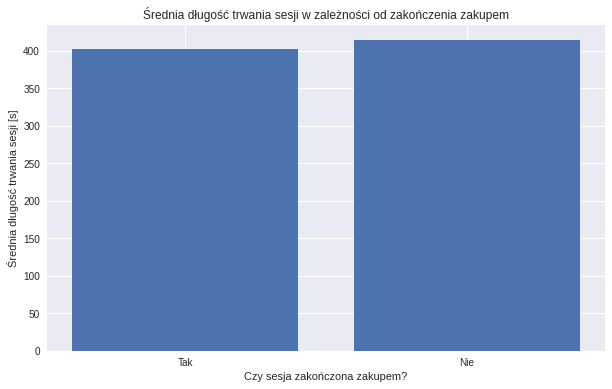

In [336]:
plt.bar(['Tak', 'Nie'], [sessions_with_purchase['session_length'].mean(), sessions_without_purchase['session_length'].mean()])
plt.title('Średnia długość trwania sesji w zależności od zakończenia zakupem')
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Średnia długość trwania sesji [s]')

### Sesje niezakończone zakupem bez sesji składających się z pojedynczego wyświetlenia przedmiotu

In [20]:
sessions_without_purchase_and_0 = sessions_without_purchase.loc[sessions_without_purchase['session_length'] != 0]

/home/bartosz/.cache/pypoetry/virtualenvs/session-purchase-Nl1zfB8X-py3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Text(0, 0.5, 'Liczba sesji')

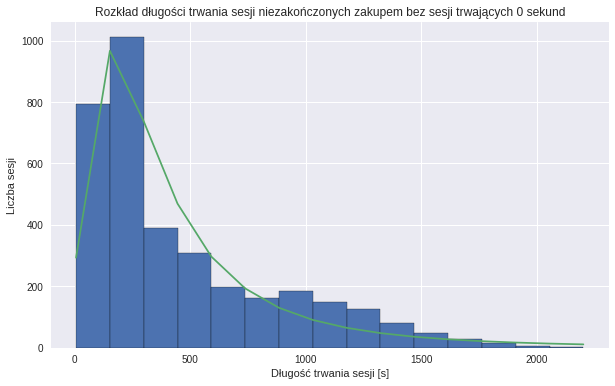

In [337]:
P = ss.invgamma.fit(sessions_without_purchase_and_0['session_length'])
n, bins, patches = plt.hist(sessions_without_purchase_and_0['session_length'], bins=15, edgecolor='black')
y = ss.invgamma.pdf(bins, *P) * np.sum(n * np.diff(bins))
plt.plot(bins, y)
plt.title('Rozkład długości trwania sesji niezakończonych zakupem bez sesji trwających 0 sekund')
plt.xlabel('Długość trwania sesji [s]')
plt.ylabel('Liczba sesji')

Poprzednie długości trwania sesji da się dobrze aproksymować rozkładem wykładniczym. Natomiast po usunięciu sesji trwających 0 lepszy efekt aproksymacji uzyskamy na przykład przy pomocy odwróconego rozkładu Gamma.

Text(0, 0.5, 'Średnia długość trwania sesji [s]')

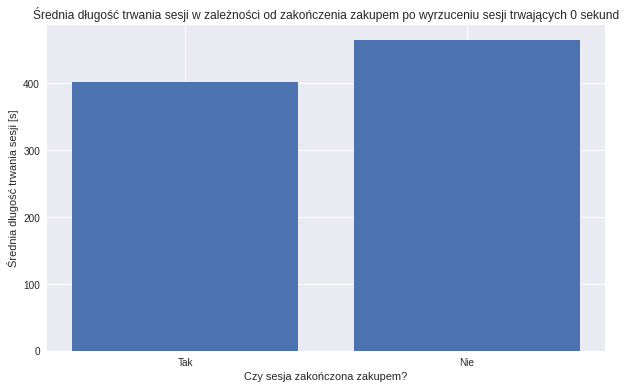

In [338]:
plt.bar(['Tak', 'Nie'], [sessions_with_purchase['session_length'].mean(), sessions_without_purchase_and_0['session_length'].mean()])
plt.title('Średnia długość trwania sesji w zależności od zakończenia zakupem po wyrzuceniu sesji trwających 0 sekund')
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Średnia długość trwania sesji [s]')

Wniosek jest taki, że sesje niezakończone zakupem to głównie sesje:
- składające się z pojedynczego wyświetlenia przedmiotu
- trwające dłużej czasu niż sesje zakończone zakupem

Być może sesje składające się z pojedynczego wyświetlenia przedmiotu powinny być wyrzucone ze zbioru danych - mogą to być sesje użytkowników niezainteresowanych szerzej ofertą sklepu w danym momencie, mogli oni być przekierowani na stronę sklepu na przykład za pośrednictwem linka od znajomego.


Sesje niezakończone zakupem przeważnie trwają dłużej niż sesje zakończone zakupem, aczkolwiek średni czas trwania sesji jest podobny, ponieważ istnieją też sesje niezakończone zakupem, które trwają 0 sekund.

### Długość trwania sesji w poszczególnych miastach

Text(0.5, 1.0, 'Długość trwania sesji w poszczególnych miastach')

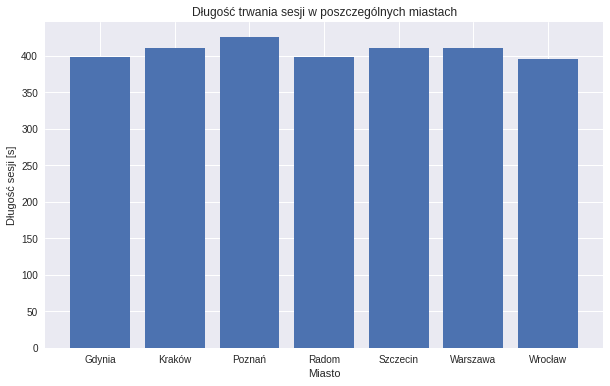

In [339]:
plt.bar(df.groupby(df['city'])['session_length'].agg('mean').keys().values, df.groupby(df['city'])['session_length'].agg('mean').values)
plt.ylabel('Długość sesji [s]')
plt.xlabel('Miasto')
plt.title('Długość trwania sesji w poszczególnych miastach')

Text(0.5, 1.0, 'Sesje niezakończone zakupem')

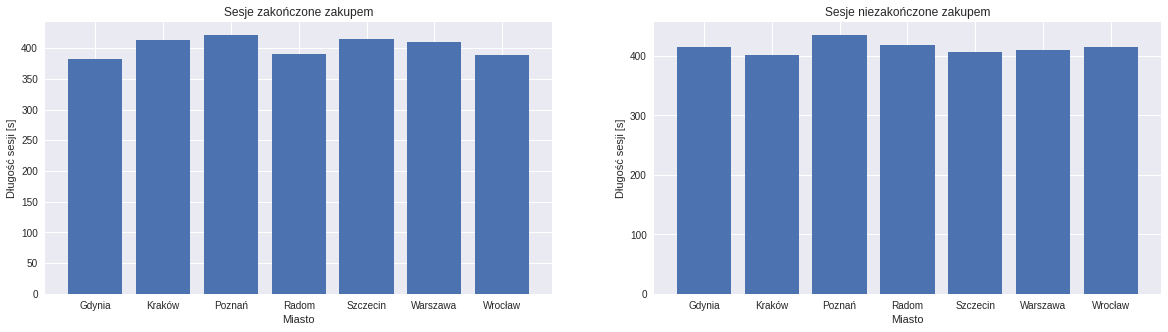

In [343]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax[0].bar(sessions_with_purchase.groupby(sessions_with_purchase['city'])['session_length'].agg('mean').keys().values,
        sessions_with_purchase.groupby(sessions_with_purchase['city'])['session_length'].agg('mean').values)
ax[0].set_ylabel('Długość sesji [s]')
ax[0].set_xlabel('Miasto')
ax[0].set_title('Sesje zakończone zakupem')

ax[1].bar(sessions_without_purchase.groupby(sessions_without_purchase['city'])['session_length'].agg('mean').keys().values,
          sessions_without_purchase.groupby(sessions_without_purchase['city'])['session_length'].agg('mean').values)
ax[1].set_ylabel('Długość sesji [s]')
ax[1].set_xlabel('Miasto')
ax[1].set_title('Sesje niezakończone zakupem')

W każdym mieście średnia długość trwania sesji jest podobna.

## Czas w którym trwały sesje

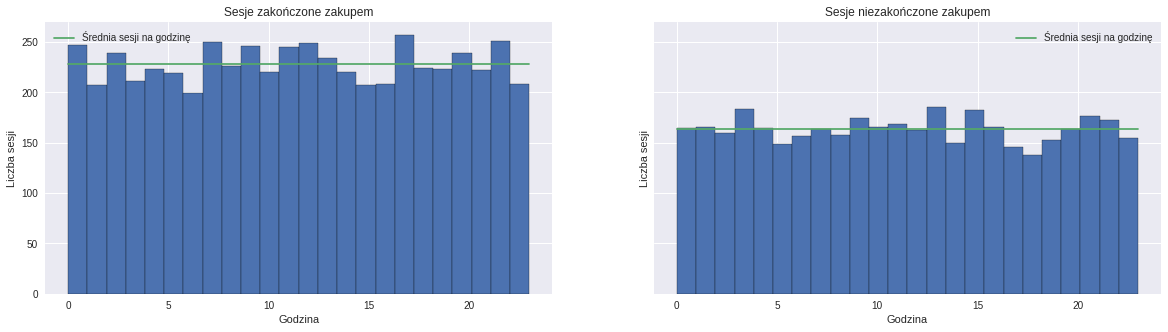

In [344]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

ax[0].hist(sessions_with_purchase['session_start'].dt.hour, bins=24, edgecolor='black')
ax[0].plot(np.arange(24), [sessions_with_purchase.shape[0]/24]*24, label='Średnia sesji na godzinę')
ax[0].set_title('Sesje zakończone zakupem')
ax[0].set_xlabel('Godzina')
ax[0].set_ylabel('Liczba sesji')
ax[0].legend()

ax[1].hist(sessions_without_purchase['session_start'].dt.hour, bins=24, edgecolor='black')
ax[1].plot(np.arange(24), [sessions_without_purchase.shape[0]/24]*24, label='Średnia sesji na godzinę')
ax[1].set_title('Sesje niezakończone zakupem')
ax[1].set_xlabel('Godzina')
ax[1].set_ylabel('Liczba sesji')
ax[1].legend()

Liczba sesji nie odbiega znacznie od średniej w żadnym z przypadków, jednak da się zauważyć pewne prawidłowości.<br>
Dla sesji zakończonych zakupem:
- Więcej niż zwykle sesji dokonuje się w godzinach: 24, 7, 17 oraz 22
- Mniej niż zwykle sesji dokonuje się w godzinach: 1, 6, 15, 16 oraz 23

Dla sesji niezkończonych zakupem:
- Więcej niż zwykle sesji dokonuje się w godzinach: 3, 13 oraz 15
- Mniej niż zwykle sesji dokonuje się w godzinach: 5, 14, 17 oraz 18

## Miasta zamieszkania użytkowników

In [23]:
df['city'].value_counts()

Warszawa    1942
Poznań      1617
Gdynia      1386
Radom       1383
Szczecin    1138
Wrocław     1120
Kraków       817
Name: city, dtype: int64

Text(0, 0.5, 'Liczba użytkowników')

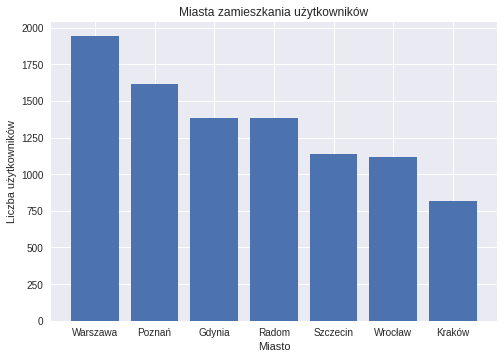

In [24]:
plt.bar(df['city'].value_counts().keys(), df['city'].value_counts())
plt.title('Miasta zamieszkania użytkowników')
plt.xlabel('Miasto')
plt.ylabel('Liczba użytkowników')

<AxesSubplot:ylabel='Miasto'>

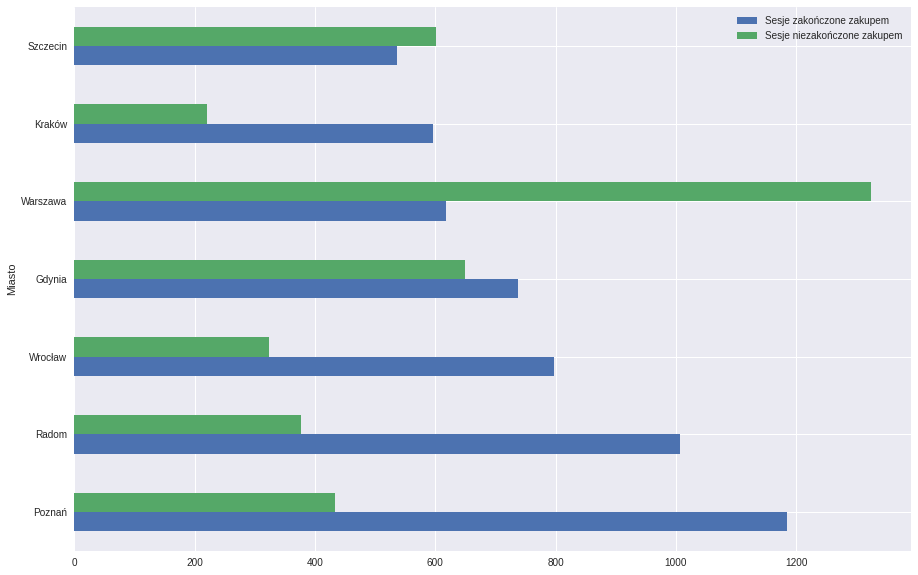

In [249]:
pd.concat([sessions_with_purchase['city'].value_counts().rename('Sesje zakończone zakupem'), sessions_without_purchase['city'].value_counts().rename('Sesje niezakończone zakupem')], axis=1).plot.barh(figsize=(15,10), xlabel='Miasto', ylabel='Liczba sesji')

Na podstawie powyższych wykresów, można dojść do ciekawych wniosków:
- Mimo tego, że jest najwięcej użytkowników z Warszawy, znaczna większość z nich nie dokonuje zakupu w sklepie.
- Miasto użytkownika niesie za sobą stosunkowo dużą informację, bo w większości miast jest wyraźna różnica między liczbą sesji zakończonych zakupem, a liczbą sesji niezakończonych zakupem

## Liczba wyświetleń produktów w trakcie sesji

In [192]:
products_not_purchased = sessions_without_purchase['product_id'].values
avg_n_views_not_purchased = np.mean([len(product_list) for product_list in products_not_purchased])
avg_n_views_not_purchased

3.8617968948841943

In [193]:
products_purchased = sessions_with_purchase['product_id'].values
avg_n_views_purchased = np.mean([len(product_list) for product_list in products_purchased])
avg_n_views_purchased

2.5418341249543297

Text(0, 0.5, 'Średnia liczba wyświetleń')

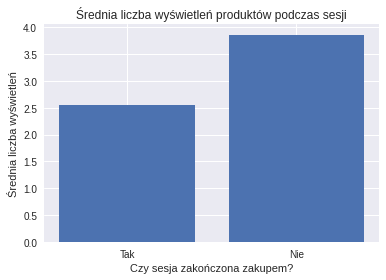

In [194]:
plt.bar(['Tak', 'Nie'], [avg_n_views_purchased, avg_n_views_not_purchased])
plt.title('Średnia liczba wyświetleń produktów podczas sesji')
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Średnia liczba wyświetleń')

Text(0, 0.5, 'Liczba sesji')

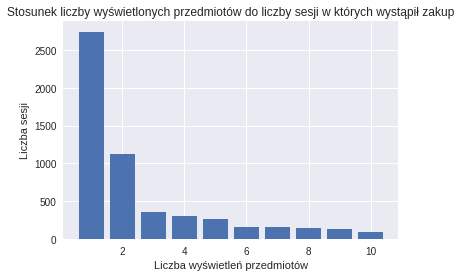

In [215]:
product_views = Counter(np.array([len(x) for x in products_purchased]))
plt.bar(product_views.keys(), product_views.values())
plt.title('Stosunek liczby wyświetlonych przedmiotów do liczby sesji w których wystąpił zakup')
plt.xlabel('Liczba wyświetleń przedmiotów')
plt.ylabel('Liczba sesji')

Z tego wynika, że istnieje tendencja taka, że im użytkownik dłużej przegląda produkty tym jest mniejsza szansa że sesja zakończy się zakupem. Wynikać to może z tego, że większośc użytkowników, którzy chcą coś kupić są zdecydowani i nie potrzebują przeglądać wiele przedmiotów. Wiele wyświetleń natomiast może znaczyć o niezdecydowaniu użytkownika - może on tylko przeglądać ofertę sklepu bez zamiaru kupna.

Dodać notakę, że rozważalibyśmy analize sprzedaży w zależności od pory roku, gdybyśmy mieli dane z listopada i grudpnia 2020.

## Liczba sesji w każdej godzinie dla miast

#### Sesje zakończone zakupem

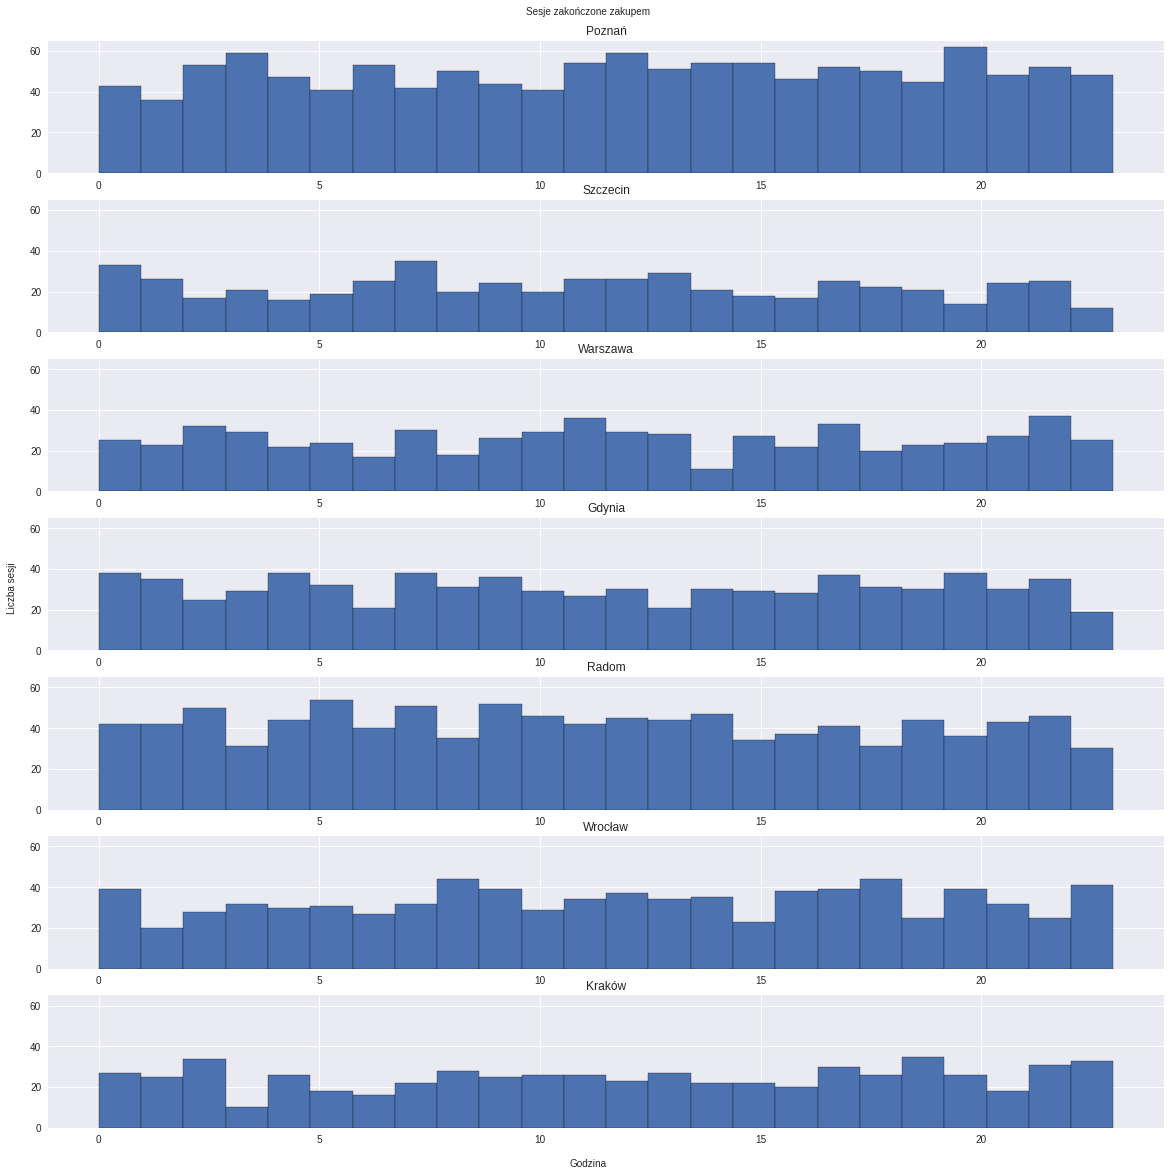

In [308]:
fig, ax = plt.subplots(nrows=7, ncols=1, sharex='row', sharey='col', figsize=(20,20))
fig.text(0.5, 0.9, 'Sesje zakończone zakupem', ha='center', va='center')
fig.text(0.5, 0.1, 'Godzina', ha='center', va='center')
fig.text(0.1, 0.5, 'Liczba sesji', ha='center', va='center', rotation='vertical')

for i, city in enumerate(df['city'].unique()):
    ax[i].hist(sessions_with_purchase.loc[sessions_with_purchase['city'] == city]['session_start'].dt.hour, bins=24, edgecolor='black')
    ax[i].set_title(city)

#### Sesje niezakończone zakupem

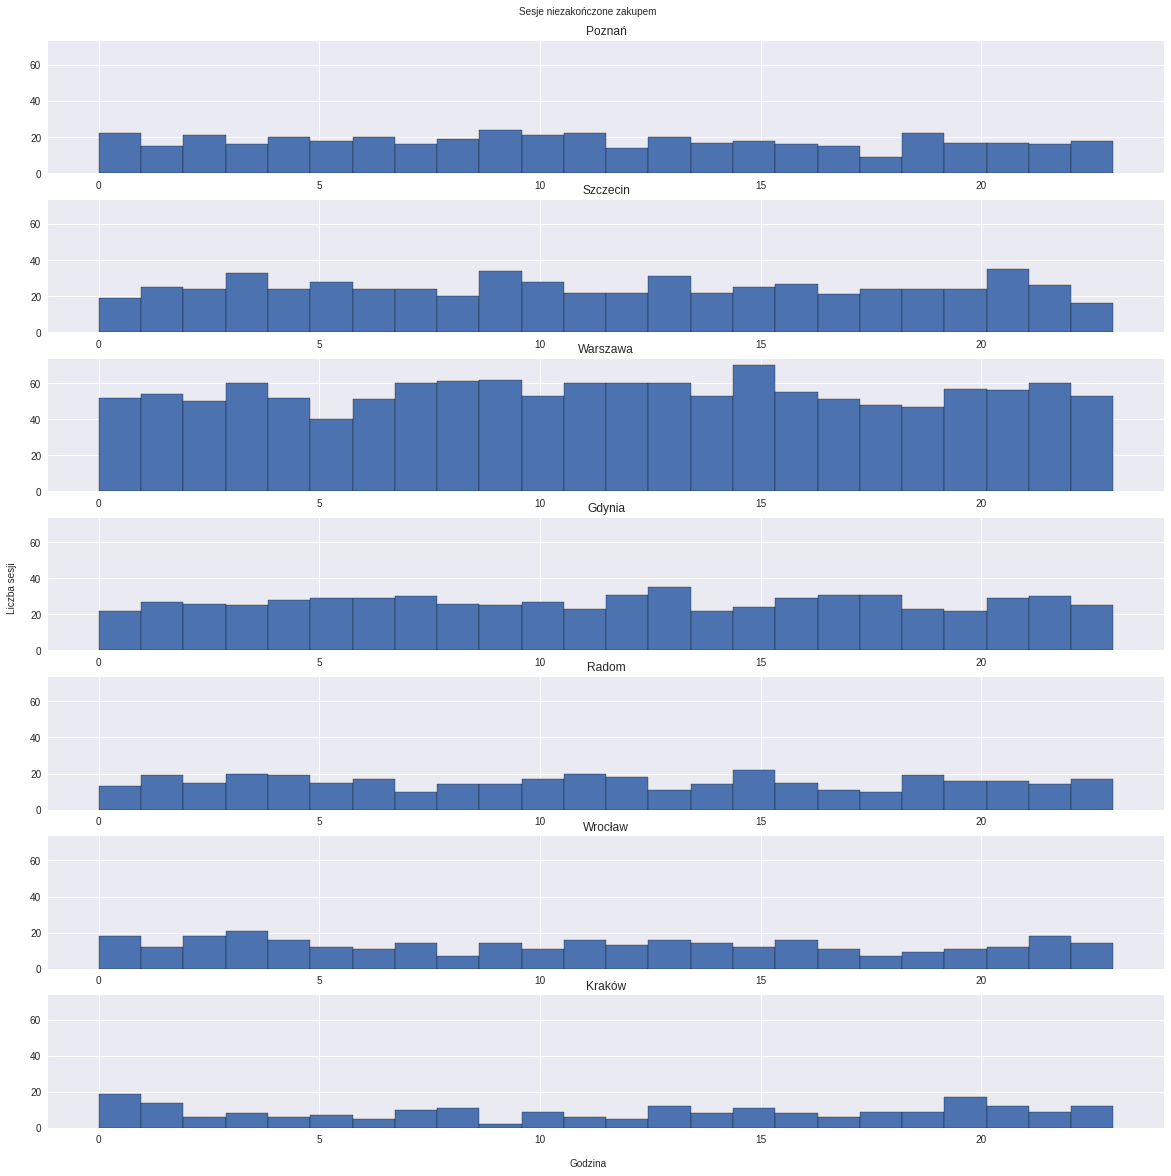

In [310]:
fig, ax = plt.subplots(nrows=7, ncols=1, sharex='row', sharey='col', figsize=(20,20))
fig.text(0.5, 0.9, 'Sesje niezakończone zakupem', ha='center', va='center')
fig.text(0.5, 0.1, 'Godzina', ha='center', va='center')
fig.text(0.1, 0.5, 'Liczba sesji', ha='center', va='center', rotation='vertical')

for i, city in enumerate(df['city'].unique()):
    ax[i].hist(sessions_without_purchase.loc[sessions_without_purchase['city'] == city]['session_start'].dt.hour, bins=24, edgecolor='black')
    ax[i].set_title(city)

Na podstawie powyższych wykresów zauważyć można pewne zależności między godziną sesji, a miastami.
Przykładowo w Warszawie najmniej sesji zakończonych zakupem zarejestrowano o godzinie 14, natomiast ta sama godzina jest jedną z najobfitszych w sesje zakończone zakupem w Poznaniu i Radomiu.